This is another multiple image input model, a model only with images but no additional predictors. It slices each image vertically into 4 same-sized images and then feeds them simultanously into the model. To build and test the model, we tend to think that it is probably better to use images as the only predictor of a person's age. Don't use other features such as eruption, gender, tooth position, etc.  

#### The Packages

Not all packages are necessary, but load them all nonetheless. 

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import tempfile
from datetime import datetime
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
from math import sqrt,exp
from google.colab.patches import cv2_imshow
import helper as hp
from __future__ import division
import math
from sklearn.model_selection import GroupShuffleSplit 
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#### Drive mounting and directory setting

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


This analysis takes the manually cropped & horizontally aligned images (not the original images), which are stored in the folder "Images_cropped".

In [3]:
project_dir = "/gdrive/My Drive/Propulsion_Academy/TCA_Project/TCA_project_Tomek_Thomas/tooth-annulation/"
image_dir = project_dir + "data/Images_cropped/"
%cd {project_dir} 
%pwd

/gdrive/My Drive/Propulsion_Academy/TCA_Project/TCA_project_Tomek_Thomas/tooth-annulation


'/gdrive/My Drive/Propulsion_Academy/TCA_Project/TCA_project_Tomek_Thomas/tooth-annulation'

#### Load the data

here, we load the data, then we create age categories. Next, we create a tooth id (ID_tooth) by concatinating ID and Tooth.Code. We also dropped people below 20 years of age. Note that when you load the data, you might need to consider changing data type (Sex & Tooth.Code should not be a float64 data type) 

In [4]:
#data = pd.read_csv(project_dir + 'data/clean_meta.csv')
#data = pd.read_excel(project_dir + 'data/Metadata_clean.xlsx')
data = pd.read_csv(project_dir + 'data/meta.csv')
bins = [0, 29.9, 39.9, 49.9, 59.9, 69.9, 79.9, 110]
group_names = ['<30', '30-39', '40-49', '50-59', '60-69', '70-79', '>80']
data['age_groups'] = pd.cut(data['Age'], bins, labels=group_names)
data['ID_tooth'] = data['ID'].astype(str) + '_' + data['Tooth.Code'].astype(str)
data = data[data['Age'] > 20]
#data = data.drop('Unnamed: 0', axis= 1)
print(data.shape)
print(data.info())
data.head()

(2529, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2529 entries, 0 to 2562
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  2529 non-null   int64   
 1   ID          2529 non-null   int64   
 2   Tooth.Code  2529 non-null   float64 
 3   Age         2529 non-null   float64 
 4   Sex         2529 non-null   float64 
 5   ImgID       2529 non-null   int64   
 6   ImgName     2529 non-null   object  
 7   eruption    2529 non-null   float64 
 8   age_groups  2529 non-null   category
 9   ID_tooth    2529 non-null   object  
dtypes: category(1), float64(4), int64(3), object(2)
memory usage: 200.4+ KB
None


,Unnamed: 0,ID,Tooth.Code,Age,Sex,ImgID,ImgName,eruption,age_groups,ID_tooth
0,0,1,44.0,80.25,0.0,138,001_44_NA_80.25_0138.tif,10.0,>80,1_44.0
1,1,1,44.0,80.25,0.0,139,001_44_NA_80.25_0139.tif,10.0,>80,1_44.0
2,2,1,44.0,80.25,0.0,368,001_44_NA_80.25_0368.tif,10.0,>80,1_44.0
3,3,1,44.0,80.25,0.0,369,001_44_NA_80.25_0369.tif,10.0,>80,1_44.0
4,4,2,12.0,46.00,2.0,140,002_12_2_46_0140.tif,8.5,40-49,2_12.0


In [5]:
data['Tooth.Code'] = data['Tooth.Code'].astype(str)
data['ImgName'] = data['ImgName'].astype(str)

In [6]:
data['ImgName']

0       001_44_NA_80.25_0138.tif
1       001_44_NA_80.25_0139.tif
2       001_44_NA_80.25_0368.tif
3       001_44_NA_80.25_0369.tif
4           002_12_2_46_0140.tif
                  ...           
2558      571_44_1_22.5_3708.tif
2559      571_44_1_22.5_3710.tif
2560      572_24_1_22.5_3706.tif
2561      573_14_1_22.5_3676.tif
2562      574_34_1_22.5_3674.tif
Name: ImgName, Length: 2529, dtype: object

If you want to use tooth code for your analysis you might need to creat dummies. 

In [7]:
tooth_dummies = pd.get_dummies(data['Tooth.Code'])

In [8]:
print(tooth_dummies.shape, data.shape)
data = pd.concat([data, tooth_dummies], axis=1)
data.info()

(2529, 20) (2529, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2529 entries, 0 to 2562
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  2529 non-null   int64   
 1   ID          2529 non-null   int64   
 2   Tooth.Code  2529 non-null   object  
 3   Age         2529 non-null   float64 
 4   Sex         2529 non-null   float64 
 5   ImgID       2529 non-null   int64   
 6   ImgName     2529 non-null   object  
 7   eruption    2529 non-null   float64 
 8   age_groups  2529 non-null   category
 9   ID_tooth    2529 non-null   object  
 10  11.0        2529 non-null   uint8   
 11  12.0        2529 non-null   uint8   
 12  13.0        2529 non-null   uint8   
 13  14.0        2529 non-null   uint8   
 14  15.0        2529 non-null   uint8   
 15  21.0        2529 non-null   uint8   
 16  22.0        2529 non-null   uint8   
 17  23.0        2529 non-null   uint8   
 18  24.0        2529 non-null 

In image processing the criterion variable is often scaled (0-1). I am not entirely sure why, but I guess it is computational less demanding (faster). Note that at some point you also scale the image pixels (brightness) down from 0-255 to 0-1.

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['Age_scaled'] = min_max_scaler.fit_transform(data[['Age']])

In [10]:
current_folder_content = glob.glob(project_dir + "data/Images_cropped/" + "*")
len(current_folder_content)

924

In [11]:
'''' alternative way
import glob
files_names = []
for file in glob.glob(project_dir + "data/Images_cropped/" + "*"):
    file1 = file.split('/', 9)[-1]
    files_names.append(os.path.relpath(file1))
'''

'\' alternative way\nimport glob\nfiles_names = []\nfor file in glob.glob(project_dir + "data/Images_cropped/" + "*"):\n    file1 = file.split(\'/\', 9)[-1]\n    files_names.append(os.path.relpath(file1))\n'

In [12]:
image_name_list= [] #contain all image names

for image in current_folder_content:
  image_name = image.split('/', 10)[-1]
  image_name_list.append(image_name)

print(len(image_name_list))
print(type(image_name_list))
image_name_list[0:5]

924
<class 'list'>


['002_12_2_46_0140.jpg',
 '002_12_2_46_0142.jpg',
 '002_12_2_46_0144.jpg',
 '005_21_2_46_0149.jpg',
 '005_21_2_46_0177.jpg']

the step below was needed because we stored the manually cropped images by overwriting ".tif" with ".jpg". 

In [13]:
data['ImgName'] = data['ImgName'].str.replace('.tif', '.jpg')
## let us have a look. ImgName entries always end with ".jpg".
data.head(6)

,Unnamed: 0,ID,Tooth.Code,Age,Sex,ImgID,ImgName,eruption,age_groups,ID_tooth,11.0,12.0,13.0,14.0,15.0,21.0,22.0,23.0,24.0,25.0,31.0,32.0,33.0,34.0,35.0,41.0,42.0,43.0,44.0,45.0,Age_scaled
0,0,1,44.0,80.25,0.0,138,001_44_NA_80.25_0138.jpg,10.0,>80,1_44.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.877778
1,1,1,44.0,80.25,0.0,139,001_44_NA_80.25_0139.jpg,10.0,>80,1_44.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.877778
2,2,1,44.0,80.25,0.0,368,001_44_NA_80.25_0368.jpg,10.0,>80,1_44.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.877778
3,3,1,44.0,80.25,0.0,369,001_44_NA_80.25_0369.jpg,10.0,>80,1_44.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.877778
4,4,2,12.0,46.00,2.0,140,002_12_2_46_0140.jpg,8.5,40-49,2_12.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.370370
5,5,2,12.0,46.00,2.0,141,002_12_2_46_0141.jpg,8.5,40-49,2_12.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.370370


we only selected images which are also included in "image_name_list".

In [14]:
data = data[data['ImgName'].isin(image_name_list)]

In [15]:
len(data)

906

cannot really recall why I had to reset the index. It is probably due to the step where tooth code dummy data frame was merged with the other data frame.

In [16]:
data.reset_index(drop=True, inplace=True)

check out correlations between tooth code and age.

In [17]:
corr = data.corr()
corr

,Unnamed: 0,ID,Age,Sex,ImgID,eruption,11.0,12.0,13.0,14.0,15.0,21.0,22.0,23.0,24.0,25.0,31.0,32.0,33.0,34.0,35.0,41.0,42.0,43.0,44.0,45.0,Age_scaled
Unnamed: 0,1.000000,0.995439,-0.019565,-0.204253,0.750916,-0.039812,-0.008795,0.022981,0.011819,0.001815,-0.024517,-0.068234,-0.016689,-0.081563,-0.006967,-0.029637,0.046886,0.011884,-0.077965,-0.173544,-0.013718,0.027073,0.083011,0.129279,0.028202,0.088534,-0.019565
ID,0.995439,1.000000,-0.022491,-0.192965,0.735861,-0.035820,-0.018144,0.024856,0.010242,0.001482,-0.023570,-0.074116,-0.012347,-0.079667,-0.008494,-0.036118,0.041491,0.016026,-0.072922,-0.169361,-0.011674,0.029686,0.084911,0.139339,0.016748,0.087088,-0.022491
Age,-0.019565,-0.022491,1.000000,-0.099107,-0.031482,-0.102187,-0.009698,-0.062392,-0.095285,-0.170753,-0.045741,0.057797,-0.104436,-0.163587,-0.023464,-0.032910,0.031680,0.188941,0.218557,0.039904,-0.042565,-0.005229,0.086311,0.030727,-0.003775,-0.069377,1.000000
Sex,-0.204253,-0.192965,-0.099107,1.000000,-0.200403,0.091249,-0.006985,-0.029760,-0.012246,-0.053332,0.050894,0.100337,0.119980,0.097765,-0.019611,0.064934,-0.028592,-0.135758,-0.108566,0.085350,-0.033849,-0.046665,-0.098942,0.013769,0.089278,0.095831,-0.099107
ImgID,0.750916,0.735861,-0.031482,-0.200403,1.000000,-0.020264,-0.040981,-0.004983,0.019822,-0.016876,-0.044164,-0.074203,-0.039373,0.023662,0.012205,-0.032006,0.091935,-0.013243,-0.051507,-0.170150,-0.027468,-0.001374,0.102440,0.139888,0.060049,0.039871,-0.031482
eruption,-0.039812,-0.035820,-0.102187,0.091249,-0.020264,1.000000,-0.196521,-0.074528,0.220743,0.186367,0.241030,-0.163124,-0.052333,0.269901,0.158955,0.110203,-0.389093,-0.192982,0.255871,0.174688,0.185263,-0.415359,-0.174717,0.197373,0.168695,0.309429,-0.102187
11.0,-0.008795,-0.018144,-0.009698,-0.006985,-0.040981,-0.196521,1.000000,-0.060039,-0.036032,-0.049611,-0.041772,-0.051573,-0.063945,-0.046188,-0.040996,-0.019099,-0.074283,-0.079586,-0.052213,-0.052848,-0.035144,-0.076238,-0.067686,-0.037752,-0.046890,-0.052848,-0.009698
12.0,0.022981,0.024856,-0.062392,-0.029760,-0.004983,-0.074528,-0.060039,1.000000,-0.039539,-0.054439,-0.045837,-0.056592,-0.070168,-0.050683,-0.044985,-0.020957,-0.081512,-0.087331,-0.057295,-0.057991,-0.038564,-0.083657,-0.074273,-0.041426,-0.051453,-0.057991,-0.062392
13.0,0.011819,0.010242,-0.095285,-0.012246,0.019822,0.220743,-0.036032,-0.039539,1.000000,-0.032671,-0.027509,-0.033963,-0.042111,-0.030417,-0.026998,-0.012577,-0.048919,-0.052411,-0.034385,-0.034803,-0.023144,-0.050206,-0.044574,-0.024861,-0.030879,-0.034803,-0.095285
14.0,0.001815,0.001482,-0.170753,-0.053332,-0.016876,0.186367,-0.049611,-0.054439,-0.032671,1.000000,-0.037875,-0.046762,-0.057980,-0.041880,-0.037172,-0.017317,-0.067354,-0.072162,-0.047343,-0.047918,-0.031866,-0.069126,-0.061372,-0.034230,-0.042516,-0.047918,-0.170753


#### Testing Image Slicing

In [18]:
def long_slice(image_path, out_name, slice_size, outdir):
    """slice an image into parts slice_size tall"""
    img = Image.open(image_path)
    width, height = img.size
    upper = 0
    left = 0
    slices = int(math.ceil(width/slice_size))

    count = 1
    for slice in range(slices):
        #if we are at the end, set the lower bound to be the bottom of the image
        if count == slices:
            lower = width
        else:
            lower = int(count * slice_size)  

        bbox = (left, upper, width, lower)
        working_slice = img.crop(bbox)
        upper += slice_size
        #save the slice
        working_slice.save(os.path.join(outdir, "slice_" + out_name + "_" + str(count)+".png"))
        count +=1

#### Test 2

In [19]:
outdir = project_dir + "data/image_slice_cropped/"
outdir

'/gdrive/My Drive/Propulsion_Academy/TCA_Project/TCA_project_Tomek_Thomas/tooth-annulation/data/image_slice_cropped/'

In [20]:
from PIL import Image
import os

def imgcrop(input, xPieces, yPieces):
    #filename, file_extension = os.path.splitext(input)
    filename = input.split('/', 10)[-1]
    im = Image.open(input)
    imgwidth, imgheight = im.size
    height = imgheight // yPieces
    width = imgwidth // xPieces
    for i in range(0, yPieces):
        for j in range(0, xPieces):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            a = im.crop(box)
            try:
                a.save(os.path.join(outdir, "slice" + "_" + filename + "_" + str(i) + "_" + str(j) + ".png"))
                #a.save(outdir + "/" + filename + "-" + str(i) + "-" + str(j) + file_extension)
            except:
                print("not saved")

#### Generator that puts slices into corresponding arrays

In [21]:
def resize(image_pil, width, height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    ratio_w = width / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:
        # It must be fixed by width
        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:
        # Fixed by height
        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (width, height), (255, 255, 255, 255))
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

The sections ResNet50 until "Generator for model with more features" can be left out.

#### ResNet50

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
base = ResNet50(include_top= False, weights= 'imagenet', pooling= 'max')
base.trainable = True
fine_tune_at = 100
for layer in base.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

##### Proof-of-Concept Model

In [ ]:
def model_constructor(input_shape, num_classes):
  input_1 = keras.Input(shape=(input_shape), name="Cropped_1")
  input_2 = keras.Input(shape=(input_shape), name="Cropped_2")
  input_3 = keras.Input(shape=(input_shape), name="Cropped_3")
  input_4 = keras.Input(shape=(input_shape), name="Cropped_4")
  combined = layers.concatenate([input_1, input_2, input_3, input_4])
  new_input = layers.Conv2D(3, 1)(combined)
  res_1 = base(new_input)
  x = layers.Dense(2048)(res_1)
  prediction = layers.Dense(num_classes, name ="Age")(x)
  return Model(inputs = [input_1, input_2, input_3, input_4], outputs= prediction)

In [ ]:
model = model_constructor(input_shape=(224, 224, 3), num_classes= 1)

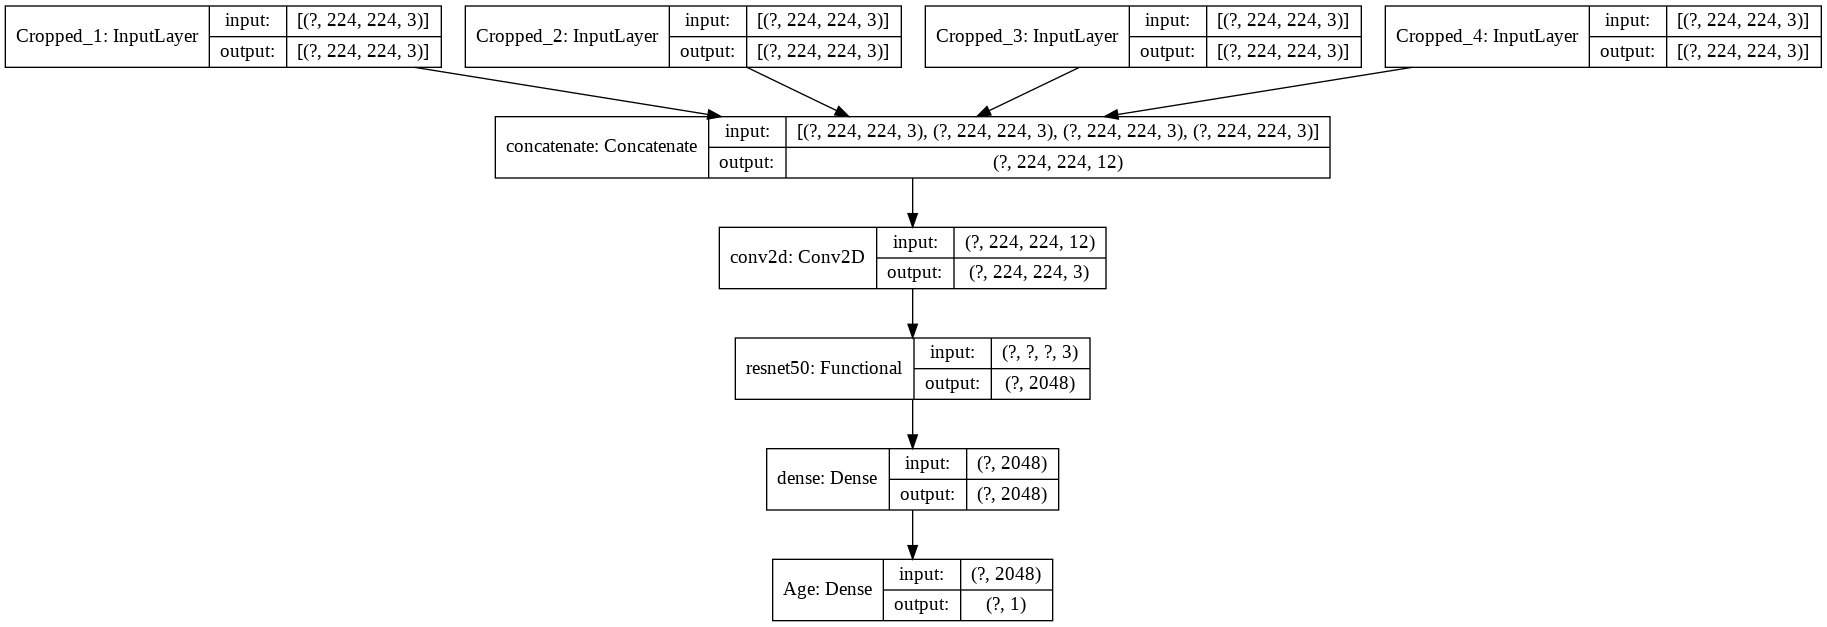

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

##### correct model

In [ ]:
def model_constructor_2(input_shape, num_classes):
  input_1 = keras.Input(shape=(input_shape), name="Cropped_1")
  res_1 = base(input_1)
  input_2 = keras.Input(shape=(input_shape), name="Cropped_2")
  res_2 = base(input_2)
  input_3 = keras.Input(shape=(input_shape), name="Cropped_3")
  res_3 = base(input_3)
  input_4 = keras.Input(shape=(input_shape), name="Cropped_4")
  res_4 = base(input_4)
  combined = layers.concatenate([res_1, res_2, res_3, res_4])
  x = layers.Dense(2048)(combined)
  prediction = layers.Dense(num_classes, name = "Age_pred")(x)
  return Model(inputs = [input_1, input_2, input_3, input_4], outputs= prediction)

In [ ]:
model_2 = model_constructor_2(input_shape=(224, 224, 3), num_classes= 1)

In [ ]:
model_2.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Cropped_1 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Cropped_2 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Cropped_3 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Cropped_4 (InputLayer)          [(None, 224, 224, 3) 0                                            
______________________________________________________________________________________

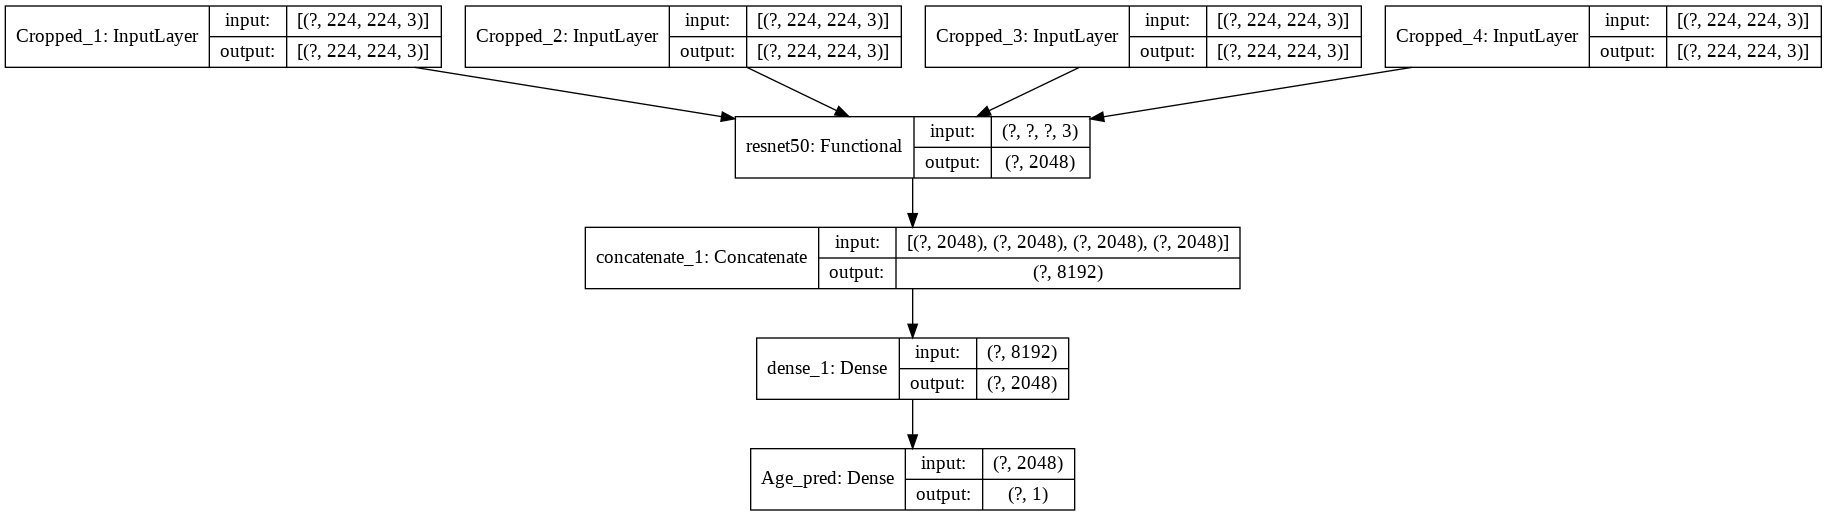

In [ ]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

#### example on how to plot with seaborn

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pred = model_2.predict(test_generator, steps=len(test_idx)//test_batch_size)

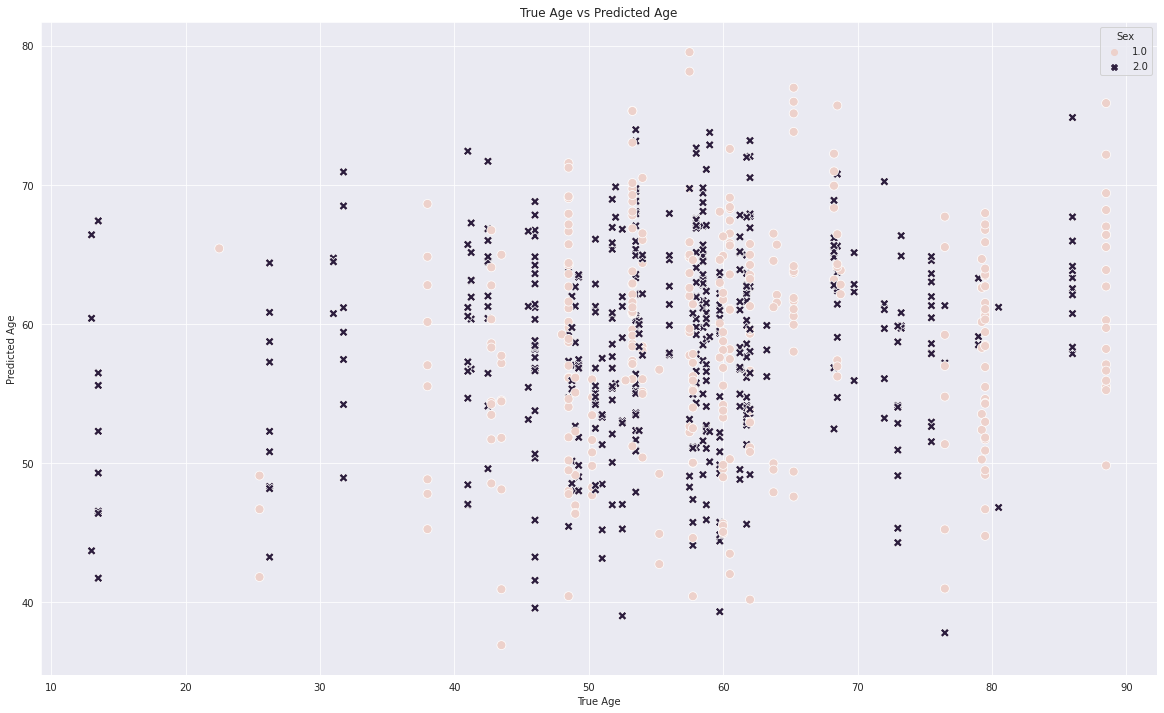

In [ ]:
fig = plt.gcf()
sns.set_style("darkgrid")
fig.set_size_inches(20, 12)
test_labels = data.iloc[test_idx]
ax = sns.scatterplot(x = test_labels['Age'], y = pred.flatten(), hue = test_labels['Sex'], style = test_labels['Sex'], edgecolor = 'w', s = 80,)
ax.set(xlabel='True Age', ylabel='Predicted Age', title = "True Age vs Predicted Age")
plt.savefig('Graphs/sliced_image_model_run.png', dpi = 180)

### Sliced Images with additional Features

#### Generator for model with more features

In [ ]:
class MultidataGenerator():

  def __init__(self, df):
        self.df = df

  def preprocess_image(self, img_path, IMG_SIZE = 390):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        
        im = tf.keras.preprocessing.image.load_img(img_path)
        im = im.resize((IMG_SIZE, IMG_SIZE))
        #img_contr_obj=ImageEnhance.Contrast(im)
        #img_sharp_obj=ImageEnhance.Sharpness(im)
        #factor=2.5
        #im=img_contr_obj.enhance(factor)
        #im = img_sharp_obj.enhance(factor)
        im = np.array(im).astype(np.float32) / 255.0
        im = tf.keras.preprocessing.image.random_brightness(im, brightness_range=(0.9, 1.2))
        im = tf.keras.preprocessing.image.random_rotation(im, 5)
        #im = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')
        #im = tf.keras.preprocessing.image.random_shear(im, intensity= 0.00005)
        im = tf.keras.preprocessing.image.random_zoom(im, (0.9, 1.1))
        return im
  
  def generate_images(self, image_idx, is_training, batch_size=16, IMG_SIZE = 390):
    crop_1, crop_2, crop_3, crop_4, sex, eruptions, ages = [], [], [], [], [], [], []
    while True:
      for idx in image_idx:
        slice = self.df.iloc[idx]
        age = slice['Age_scaled'],
        ages.append(age)
        gender = slice['Sex_scaled']
        sex.append(gender)
        eruption = slice['eruption_scaled']
        eruptions.append(eruption)
        image = slice['ImgName']
        im = self.preprocess_image(image_dir + image, IMG_SIZE = IMG_SIZE)  
        imgwidth, imgheight = im.shape[0], im.shape[1]
        height = imgheight // 1
        width = imgwidth // 4
        for i in range(0, 1):
          for j in range(0, 4):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            im = tf.keras.preprocessing.image.array_to_img(im)
            a = im.crop(box)
            final = resize(a, 390, 390)
            final = tf.keras.preprocessing.image.img_to_array(final)
            if j == 0:
                crop_1.append(final)
            if j == 1:
                crop_2.append(final)
            if j == 2:
                crop_3.append(final)
            if j == 3:
                crop_4.append(final)

            
            # yielding condition
        if len(ages) >= batch_size:
          yield [np.array(crop_1),np.array(crop_2),np.array(crop_3), np.array(crop_4), np.array(sex), np.array(eruptions)] , np.array(ages)
          crop_1, crop_2, crop_3, crop_4, sex, eruptions, ages = [], [], [], [], [], [], []
    
      if not is_training:
        break

In [ ]:
new_datagenerator = MultidataGenerator(data)

# train-test-validation-split

In ML, we split the data into a train, validation, and test set. We use the train and validation set to build the model, and the test set to evaluate the accuracy of the model. Whenever you split the data you need to decide which portion of the data should be assigned to the train set. Usually, it is around 60-80%. The sample_df function is used for the oversampling of the minority class (age groups which are less frequent than other groups). 

In [22]:
from sklearn.utils import shuffle
def sample_df(df, col_name='age_groups', n_sample_per_class=140, replace = True):
    """
    samples the dataframe based on a column, duplicates only if the 
number of initial rows < required sample size
    """
    
    samples = df.groupby(col_name)
    list_cls = df[col_name].unique()
    df_lst = []
    for cls in list_cls:
        cls_df = samples.get_group(cls)
        if (cls_df.shape[0] < n_sample_per_class) and (replace==False):
            cls_sample = cls_df
        else:
            cls_sample = cls_df.sample(n=n_sample_per_class,replace=replace,random_state=40)
        df_lst.append(cls_sample)
      
    df_sampled = pd.concat(df_lst, sort=False)
    df_sampled = shuffle(df_sampled)
    
    return df_sampled

In [23]:
data.shape

(906, 31)

While the data shape is 906x31 (we won't use most of the columns in the analysis), we create actually a larger train set through data augmentation. Data set splitting is done with GroupShuffleSplit.

In [24]:
from sklearn.model_selection import GroupShuffleSplit

### we take 70% for the train set, split first into train vs test set
### and we make sure that images from the same tooth (using ID_tooth) remain within the same set.
### we also make sure that each age group in the train set has 176 images.

train, test1 = next(GroupShuffleSplit(train_size=0.70, n_splits=2, random_state=3442).split(data, groups=data['ID_tooth']))
train_data = data.iloc[train]
train_data = sample_df(train_data, col_name='age_groups', n_sample_per_class=176, replace = True)
train_idx = train_data.index
test_data = data.iloc[test1]

## validation and test set have more or less the same size
test, valid = next(GroupShuffleSplit(test_size=0.50, n_splits=2, random_state=3442).split(test_data, groups=test_data['ID_tooth']))
test_data_true= test_data.iloc[test]
test_idx = test_data_true.index
valid_data = test_data.iloc[valid]
valid_idx = valid_data.index

In [25]:
print(len(valid_idx), len(test_idx), len(train_idx))
print(len(valid_data), len(test_data_true), len(train_data))

144 130 1232
144 130 1232


There probably exist better ways to split data. We only made sure that images from the same tooth are assigned to the same set (train, validation, or test set). 
Note, in the train set (train_data) we decided to have the equal number of observations in each age category (we accomplished this by upsampling the minority classes). This is just one way to deal with class imbalance (alternatives include class weighting or downsampling). You can also check the similarity in age distribution between the validation set and the test set.

As you can see, in the test and validation sets people aged between 50-59 are overrepresented, and people of age 39 and younger are underrepresented. Oversampling in the train set ensures that the model also learns to predict the age of age groups which are underrepresented. But data augmentation has its limits (images in the oversampled minority class are similar to one another as some are just slightly modified versions of the same image). 

In [26]:
print("Age distribution in the TRAIN set:", "\n", train_data['age_groups'].value_counts(),"\n")
print("Age distribution in the VALIDATION set:", "\n", valid_data['age_groups'].value_counts(), "\n")
print("Age distribution in the TEST set:", "\n", test_data_true['age_groups'].value_counts(), "\n")

Age distribution in the TRAIN set: 
 >80      176
70-79    176
60-69    176
50-59    176
40-49    176
30-39    176
<30      176
Name: age_groups, dtype: int64 

Age distribution in the VALIDATION set: 
 50-59    51
40-49    32
70-79    23
60-69    15
>80      13
<30      10
30-39     0
Name: age_groups, dtype: int64 

Age distribution in the TEST set: 
 50-59    55
60-69    30
40-49    21
70-79     9
<30       8
>80       5
30-39     2
Name: age_groups, dtype: int64 



# Model

For this analysis, we used **Xception**. But try out other models. Thomas worked a lot with ResNet models. EfficientNetB7 was also tested. I can't tell you with great certitude which model works better for this particular problem.   

#### Multi-input model with Xception

##### Model without additional features

Let us now create a ToothdataGenerator. It includes a preprocessing function (preprocess_image), for data augmentation, and a generate function (generate_images)to vertically slice the images and to prepare the data set. Note, we opt for image size 450. There was some discussion about the optimal image resolution. When you operate with resolution size 450x450 image processing takes ages. When you operate with 290x290 you might lose some valuable information. Ideally, you would test the same model but varying image resolution. We did this, although not systematically enough.

Most image processing examples and tutorials in the internet are about identifing an object (for example, is it a dog or a cat). To analyse such images, there is less need for high resolution. But things are different when dealing with our tooth cementum annulation images.  

Note also that the criterion here is scaled age ("Age_scaled")

In [27]:
class ToothdataGenerator():

  def __init__(self, df):
        self.df = df

  def preprocess_image(self, img_path, IMG_SIZE = 450):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        we rescale the image pixel values to 0-1
        """
        im = tf.keras.preprocessing.image.load_img(img_path)
        im = im.resize((IMG_SIZE, IMG_SIZE))
        #img_contr_obj=ImageEnhance.Contrast(im)
        #img_sharp_obj=ImageEnhance.Sharpness(im)
        #factor=2.5
        #im=img_contr_obj.enhance(factor)
        #im = img_sharp_obj.enhance(factor)
        im = np.array(im).astype(np.float32) / 255.0
        im = tf.keras.preprocessing.image.random_brightness(im, brightness_range=(0.9, 1.2))
        im = tf.keras.preprocessing.image.random_rotation(im, 1)
        im = tf.keras.preprocessing.image.random_shift(im, hrg=0.01, wrg=0.1, fill_mode="reflect")
        #im = tf.keras.preprocessing.image.random_shear(im, intensity= 0.00005)
        im = tf.keras.preprocessing.image.random_zoom(im, (0.9, 1.1))
        return im
  
  def generate_images(self, image_idx, is_training, batch_size=19, IMG_SIZE = 450):
    crop_1, crop_2, crop_3, crop_4, ages = [], [], [], [], []
    while True:
      for idx in image_idx:
        slice = self.df.iloc[idx]
        age = slice['Age_scaled'],
        ages.append(age)
        image = slice['ImgName']
        im = self.preprocess_image(image_dir + image, IMG_SIZE = IMG_SIZE)  
        imgwidth, imgheight = im.shape[0], im.shape[1]
        height = imgheight // 1
        width = imgwidth // 4
        for i in range(0, 1):
          for j in range(0, 4):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            im = tf.keras.preprocessing.image.array_to_img(im)
            a = im.crop(box)
            final = resize(a, 450, 450)
            final = tf.keras.preprocessing.image.img_to_array(final)
            if j == 0:
                crop_1.append(final)
            if j == 1:
                crop_2.append(final)
            if j == 2:
                crop_3.append(final)
            if j == 3:
                crop_4.append(final)

            
            # yielding condition
        if len(ages) >= batch_size:
          yield [np.array(crop_1),[np.array(crop_2),np.array(crop_3), np.array(crop_4)]] , np.array(ages)
          crop_1, crop_2, crop_3, crop_4, ages = [], [], [], [], []
    
      if not is_training:
        break

In [29]:
datagenerator = ToothdataGenerator(data)

Here, you need to define the batch size for the train set and batch size for the validation set. Ideally, batch size should be around 30. But, my Google collab crashed whenever batch size of 30 was combined with image resolution of 450x450. 

In [30]:
batch_size = 16
valid_batch_size = 12
test_batch_size = 1
train_generator = datagenerator.generate_images(train_idx, is_training= True, batch_size= batch_size, IMG_SIZE= 450)
valid_generator = datagenerator.generate_images(valid_idx, is_training= True, batch_size= valid_batch_size, IMG_SIZE= 450)
test_generator = datagenerator.generate_images(test_idx, is_training= True, batch_size= test_batch_size, IMG_SIZE= 450)

In [31]:
from keras.applications.xception import Xception



*   Here, you might consider using pooling method "max" or "avg", and also other weights (rather than "imagenet").
*   You can also fine tune starting from earlier layers. Here, 70 is almost at the last layer of the Xception model.


**Quick Reminder**: Computer-based image processing is primarily trail-and-error. Just try out different things, and see what works best

In [32]:
base = Xception(include_top= False,
         weights = 'imagenet',
         pooling = 'max')


base.trainable = True
fine_tune_at = 70
for layer in base.layers[:fine_tune_at]:
  layer.trainable =  False

83689472/83683744 [==============================] - 1s 0us/step


Here, too, you can run the same model with a different number and sizes of dense layers and different dropout rates.

you can also test whether concatenating the images works better than averaging.

Again, building a CNN is to a large extent simply trail-and-error (if the model works, then it's good)

In [33]:
# you could also try : combined_avg = layers.Average()([Xcept_1, Xcept_2, Xcept_3, Xcept_4])


def model_constructor_2(input_shape, num_classes):
  input_1 = keras.Input(shape=(input_shape), name="Cropped_1")
  res_1 = base(input_1)
  input_2 = keras.Input(shape=(input_shape), name="Cropped_2")
  res_2 = base(input_2)
  input_3 = keras.Input(shape=(input_shape), name="Cropped_3")
  res_3 = base(input_3)
  input_4 = keras.Input(shape=(input_shape), name="Cropped_4")
  res_4 = base(input_4)
  #combined = layers.concatenate([res_1, res_2, res_3, res_4])
  combined = layers.Average()([res_1, res_2, res_3, res_4]) ## probably this is the better option than "layers.concatenate"
  x = layers.Dense(2048, kernel_initializer='normal', activation='relu')(combined) ## size could be 4096
  x = layers.Dropout(0.1)(x) ## you can add a second Dropout-layer after the next "layers.Dense"
  x = layers.Dense(1024, kernel_initializer='normal', activation='relu')(x)
  prediction = layers.Dense(num_classes, name = "Age_pred")(x)
  return Model(inputs = [input_1, input_2, input_3, input_4], outputs= prediction)

In [44]:
model_2 = model_constructor_2(input_shape=(450, 450, 3), num_classes= 1)

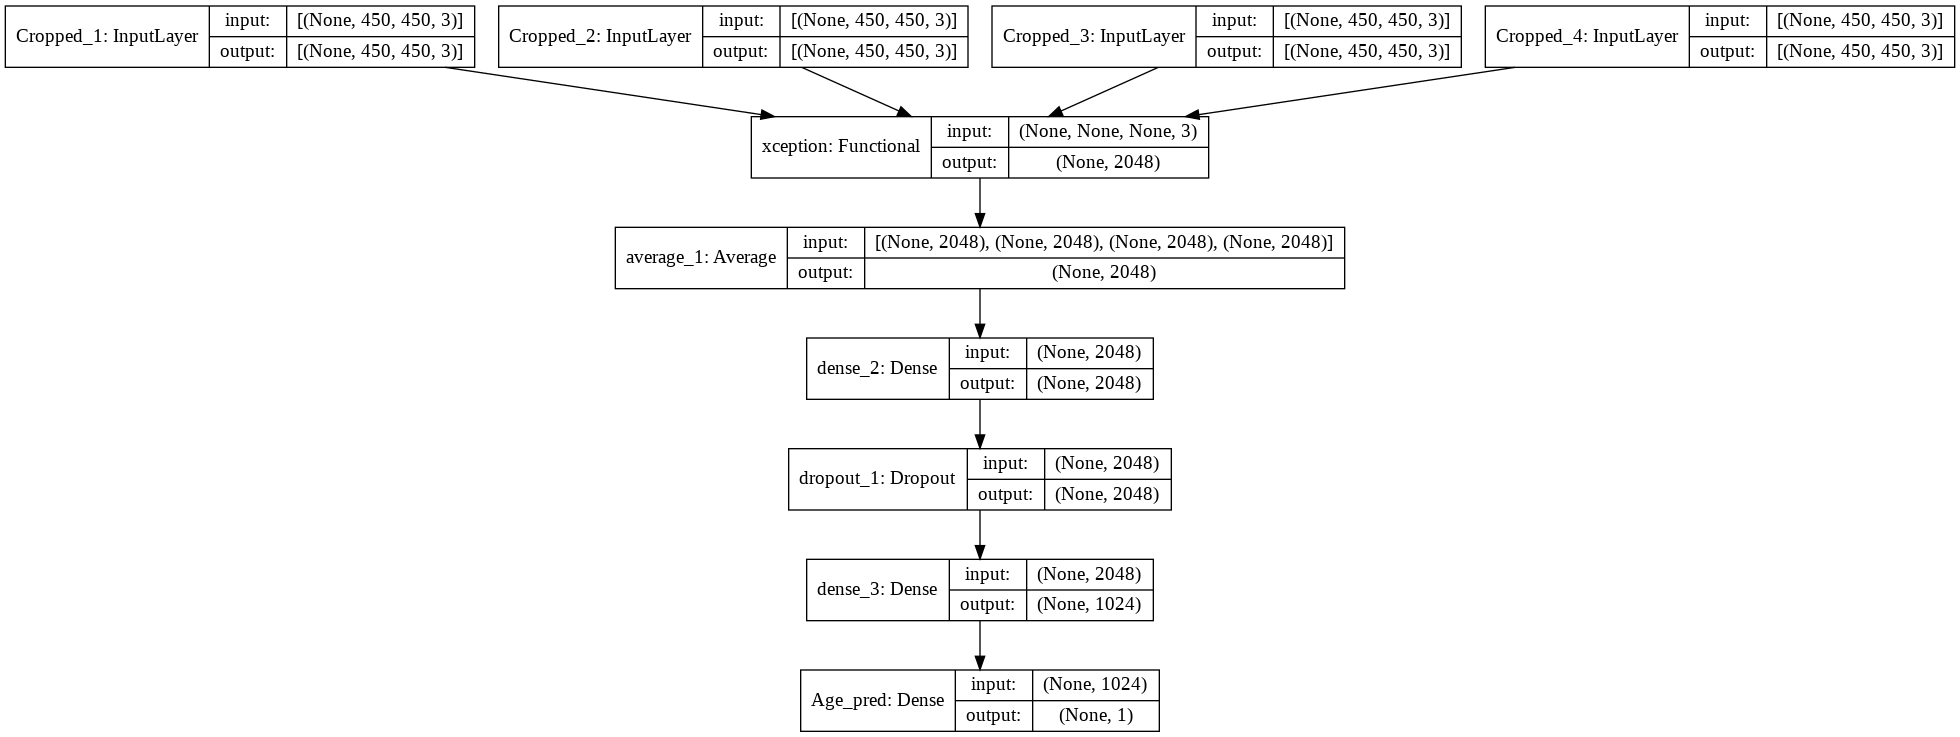

In [45]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

In [46]:
#Loss function needs to be the Mean_squared error
loss = "MeanSquaredError"

#metrics for measurement
metrics = ['RootMeanSquaredError']

#Optimizer is going to be Adam, because it is the best performing
Optimizer = Adam(learning_rate= 1e-5)

In [47]:
model_2.compile(optimizer= Optimizer, loss = loss, metrics= metrics)

Given that image processing is so complex in our case, I would recommend to test running the model with a larger number of epochs (around 150) with no early stopping.

In [48]:
#Tensorboard
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')


#model checkpoint
checkpoint_filepath = project_dir + 'models/checkpoint_multi_cropped_imagesonly.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='auto',
    save_best_only=True)
#EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=40,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
#Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=1e-7)
#CSV Logger
csv_logger = tf.keras.callbacks.CSVLogger("training_sliced_images.log", append = True)

epochs = 70
callbacks = [tboard_callback, reduce_lr, csv_logger, early_stop, checkpoint]

In [49]:
#### you can store weight and load them, next time you run the model.
#### just uncomment the last code below

#latest = tf.train.latest_checkpoint(checkpoint_dir)
#print(latest)

#model_2.load_weights(latest)

In [50]:
history = model_2.fit(train_generator,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_generator,
                    validation_steps=len(valid_idx)//valid_batch_size
                    )

StopIteration: ignored

Ideally, an RMSE of around 0.16 would have been desirable. That is not the case for the validation set.  

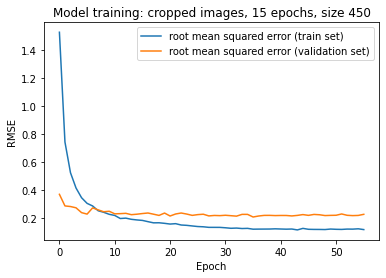

In [ ]:
import matplotlib.pyplot as plt
graphs_dir = '/gdrive/My Drive/Propulsion_Academy/TCA_Project/TCA_project_Tomek_Thomas/tooth-annulation/Graphs/'

plt.plot(history.history['root_mean_squared_error'], label='root mean squared error (train set)')
plt.plot(history.history['val_root_mean_squared_error'], label = 'root mean squared error (validation set)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Model training: cropped images, 60 epochs, size 450')

plt.legend(loc='upper right');
plt.savefig(f"{graphs_dir}/Xception3_epochs_multiple_cropped_03_04.png")

with the next code, we get the predicted values for the test set using the same model.

In [ ]:
pred = model_2.predict(test_generator, steps=len(test_idx)//test_batch_size)

NameError: ignored


Once you have the predicted values, you can compare them with the actual values. Correlation between predicted and actual age is 0.26. We got correlations of around 0.44 earlier.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
correlation_score = round(np.corrcoef(test_data_true['Age_scaled'], pred.flatten())[0][1], 2)
rmse_score = round(sqrt(mean_squared_error(test_data_true['Age_scaled'], pred.flatten())), 2)
print("Correlation between Actual and Predicted Age:", correlation_score)
print("RMSE:", rmse_score)

correlation between actual and predicted age: 0.26
RMSE: 0.22


you can save the whole model also this way

In [ ]:
history.model.save('/gdrive/My Drive/Propulsion_Academy/TCA_Project/TCA_project_Tomek_Thomas/tooth-annulation/models/Xception2_multiple_cropped2_03_04')

INFO:tensorflow:Assets written to: /gdrive/My Drive/Propulsion_Academy/TCA_Project/TCA_project_Tomek_Thomas/tooth-annulation/models/Xception2_multiple_cropped2_03_04/assets


But, overall, it is going in the right direction.

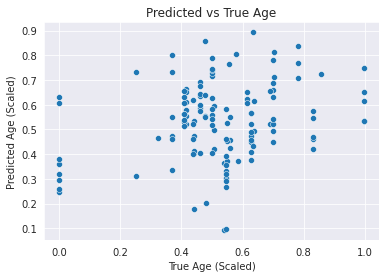

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#fig = plt.gcf()
sns.set_style("darkgrid")
#fig.set_size_inches(10, 6)
test_labels = data.iloc[test_idx] ### can remember what that piece of code was for, maybe not necessary.
ax = sns.scatterplot(x = test_data_true['Age_scaled'], y = pred.flatten())
ax.set(xlabel='True Age (Scaled)', ylabel='Predicted Age (Scaled)', title = "Predicted vs True Age")
# add text annotation
plt.show();
#plt.savefig('Graphs/cropped_sliced_multiple_scaled2.png', dpi = 560)